# Workshop Microsoft - Sostenibilidad
En el siguiente ejemplo analizaremos el coste energético de un modelo de la inferencia del modelo Phi de Microsoft.
Se puede realizar este ejemplo con CPU o GPU. En caso de ser con GPU es necesario indicarlo en los parámetros de configuración

In [ ]:
%pip install transformers==4.48 accelerate sentencepiece tokenizer codecarbon flash_attn -q
%pip install dash dash-bootstrap-components python-dotenv -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Posiblemente, sea necesario reiniciar el kernel

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline
import textwrap
from codecarbon import EmissionsTracker
from codecarbon import track_emissions
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from dotenv import load_dotenv

#os.environ["TOKENIZERS_PARALLELISM"] = "false"


load_dotenv()

True

In [ ]:
# parametros de configuración
model_name = "microsoft/Phi-3.5-mini-instruct"
project_name="worshop-ia-sostenible"

#TODO CAMBIAR RUTA DEL FICHERO
#output_dir_emissions_track="/lakehouse/default/Files"
output_dir_emissions_track="/home/azureuser/cloudfiles/code/Users/paul.vanb/worshop-ia-sostenible/outputs"
output_file_emissions_track=f"{project_name}_emissions.csv"

output_filename = os.path.join(output_dir_emissions_track,output_file_emissions_track )
device_map="auto"
cloud_region="westus2"

In [ ]:

def wrap_text(text, width=100):
    """
    Envuelve el texto dado para que cada línea no supere el ancho especificado.
    
    Args:
        text (str): El texto de entrada.
        width (int): El ancho máximo de cada línea (por defecto, 100 caracteres).
    
    Returns:
        str: Texto con saltos de línea insertados para cumplir con el ancho especificado.
    """
    lines = text.split('\n')  # Divide el texto en líneas basadas en saltos de línea existentes.
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]  # Envuelve cada línea individualmente.
    wrapped_text = '\n'.join(wrapped_lines)  # Une las líneas envueltas con saltos de línea.
    return wrapped_text

def generate(pipe, input_text, system_prompt=""):
    """
    Genera una respuesta basada en el texto de entrada utilizando un modelo de IA.
    
    Args:
        input_text (str): Texto de entrada del usuario.
        system_prompt (str): Mensaje de sistema opcional para guiar la respuesta del modelo.
        max_length (int): Longitud máxima de la respuesta generada (por defecto, 1024 caracteres).
    
    Returns:
        str: Texto generado y formateado con saltos de línea adecuados.
    """
    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }
    # Si no se proporciona un mensaje del sistema, se usa un mensaje por defecto.
    if system_prompt != "":
        system_prompt = system_prompt
    else:
        system_prompt = "You are a friendly and helpful assistant"
    
    # Construcción del historial de mensajes con el mensaje del sistema y la entrada del usuario.
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": input_text},
    ]
    
    # Generación de la respuesta del modelo.
    output = pipe(messages, **generation_args)
    text = output[0]['generated_text']  # Obtiene el texto generado.
    
    # Envuelve el texto generado para cumplir con el ancho especificado.
    wrapped_text = wrap_text(text)
    return wrapped_text

@track_emissions(project_name= project_name, output_dir=output_dir_emissions_track,
                 cloud_provider="azure", cloud_region= cloud_region, pue=1.19, output_file=output_file_emissions_track,
                 allow_multiple_runs=True)
def answer_to_different_messages(pipe,messages):
    """
    Procesa una lista de mensajes y genera respuestas mientras realiza un seguimiento de las emisiones.
    
    Args:
        messages (list): Lista de mensajes de entrada.
    
    Returns:
        list: Lista de respuestas generadas junto con los mensajes de entrada y sus identificadores.
    """
    outputs = []  # Lista para almacenar los resultados.
    system_prompt = "Eres un asistente de Microsoft experto en sostenibilidad llamado SostAI"  # Mensaje del sistema.
    
    # Itera sobre cada mensaje y genera una respuesta.
    for mid, message in enumerate(messages):
        output = generate(pipe, message, system_prompt=system_prompt)  # Genera la respuesta.
        outputs.append([mid, message, output])  # Almacena el identificador, mensaje y respuesta.
    
    return outputs  # Devuelve la lista de respuestas generadas.

###############################################
#################### PLOTS ####################
###############################################

def plot_stacked_power(df):
    """
    Genera un gráfico de barras apiladas para visualizar el consumo de potencia (CPU, GPU, RAM) a lo largo del tiempo.
    
    Args:
        df (pd.DataFrame): DataFrame que contiene las columnas 'timestamp', 'cpu_power', 'gpu_power' y 'ram_power'.
    """
    df_sorted = df.sort_values(by='timestamp')  # Ordenar por timestamp
    
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['timestamp'], df_sorted['cpu_power'], label='CPU Power', color='blue')
    plt.bar(df_sorted['timestamp'], df_sorted['gpu_power'], bottom=df_sorted['cpu_power'], label='GPU Power', color='red')
    plt.bar(df_sorted['timestamp'], df_sorted['ram_power'], bottom=df_sorted['cpu_power'] + df_sorted['gpu_power'], label='RAM Power', color='green')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (W)')
    plt.title('Stacked Power Consumption Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

def plot_stacked_energy(df):
    """
    Genera un gráfico de barras apiladas para visualizar el consumo de energía (CPU, GPU, RAM) a lo largo del tiempo.
    """
    df_sorted = df.sort_values(by='timestamp')
    
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['timestamp'], df_sorted['cpu_energy'], label='CPU Energy', color='blue')
    plt.bar(df_sorted['timestamp'], df_sorted['gpu_energy'], bottom=df_sorted['cpu_energy'], label='GPU Energy', color='red')
    plt.bar(df_sorted['timestamp'], df_sorted['ram_energy'], bottom=df_sorted['cpu_energy'] + df_sorted['gpu_energy'], label='RAM Energy', color='green')
    
    # Agregar Total Energy Consumed como una barra al lado de cada apilamiento
    bar_width = 0.28  # Definir el ancho de las barras
    x_indexes = range(len(df_sorted['timestamp']))
    plt.bar([x + bar_width for x in x_indexes], df_sorted['energy_consumed'], label='Total Energy Consumed', color='purple', alpha=0.7, width=bar_width)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Energy Consumption (kWh)')
    plt.title('Stacked Energy Consumption Over Time')
    plt.xticks([x + bar_width / 2 for x in x_indexes], df_sorted['timestamp'], rotation=45)
    plt.legend()
    plt.show()

[codecarbon INFO @ 17:38:09] Energy consumed for RAM : 0.000013 kWh. RAM Power : 3.092193603515625 W
[codecarbon INFO @ 17:38:09] Energy consumed for all CPUs : 0.000407 kWh. Total CPU Power : 97.5 W
[codecarbon INFO @ 17:38:09] 0.000419 kWh of electricity used since the beginning.


# Carga del Modelo
Usaremos la librería transformers de Hugginface para cargar el modelo de microsoft Phi-3.5 mini instruído.


In [ ]:
torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map= device_map,
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]


Probamos primero a ejecutar el modelo como se describe en Hugginface
 https://huggingface.co/microsoft/Phi-3.5-mini-instruct

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
    {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
    {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
]


output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

Device set to use cpu
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


 To solve the linear equation 2x + 3 = 7, follow these steps:

1. Subtract 3 from both sides of the equation to isolate the term with the variable (x):

   2x + 3 - 3 = 7 - 3
   2x = 4

2. Now, divide both sides of the equation by the coefficient of x (which is 2):

   2x / 2 = 4 / 2
   x = 2

So, the solution to the equation 2x + 3 = 7 is x = 2.


Probamos de la función generate

In [ ]:
print(generate(pipe,'¿Quién eres?',
         system_prompt="Eres un asistente experto de Microsoft en sostenibilidad",
         ))

 Soy Phi, IA desarrollada por Microsoft. Estoy aquí para ayudarte con tus preguntas y proporcionar
información sobre una amplia gama de temas, incluida la sostenibilidad. ¡Déjame saber cómo puedo
asistirte hoy!


# Consumo energético con CodeCarbon
A continuación, usaremos la librería codecarbon para evaluar las emisiones y el consumo energético de este modelo.

In [ ]:
#%%time
# Start tracking
tracker = EmissionsTracker(tracking_mode="process",
                           project_name="test-one-inference",
                           output_dir=output_dir_emissions_track,
                           output_file=output_file_emissions_track) # save_to_api=True,
tracker.start()

generate(pipe,'¿Quién eres?',
         system_prompt="Eres un asistente majo",
         
         )
emmissions = tracker.stop()


[codecarbon INFO @ 09:47:45] Codecarbon is taking the configuration from global file: /home/azureuser/.codecarbon.config
[codecarbon INFO @ 09:47:45] [setup] RAM Tracking...
[codecarbon INFO @ 09:47:45] [setup] CPU Tracking...
[codecarbon DEBUG @ 09:47:45] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 09:47:45] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon DEBUG @ 09:47:45] Not using PowerMetrics, an exception occurred while instantiating Powermetrics : Platform not supported by Powermetrics
[codecarbon WARNING @ 09:47:45] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon DEBUG @ 09:47:46] CPU : We detect a Intel(R) Xeon(R) Platinum 8272CL CP

CPU times: user 58.1 s, sys: 120 ms, total: 58.2 s
Wall time: 35.2 s


In [ ]:
print(f"All hardware identified:{tracker._hardware}")
print(f"GPU/CPU Power: {tracker._hardware[1].total_power()}")
print(f"Hardware zone: {tracker._geo}")
print(f"Emissions from this training run: {emmissions:5f} kg CO2eq")

All hardware identified: [RAM(), CPU(Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz > 195.0W)]
GPU/CPU Power: Power(kW=0.0975)
Hardware zone: GeoMetadata(country_iso_code=USA, country_name=United States, region=washington)
Emissions from this training run: 0.000069 kg CO2eq


Es posible calcular las emisiones de diferentes posibles maneras con codecarbon.
- con context manager
- con decorador

In [ ]:

with EmissionsTracker(output_dir=output_dir_emissions_track, output_file=output_file_emissions_track,
                      allow_multiple_runs=True) as tracker:
  generate(pipe, '¿Quién eres?',
         system_prompt="Eres un asistente majo",
         )


[codecarbon INFO @ 09:48:43] Codecarbon is taking the configuration from global file: /home/azureuser/.codecarbon.config
[codecarbon DEBUG @ 09:48:43] Lock file created. Path: /tmp/.codecarbon.lock
[codecarbon INFO @ 09:48:43] [setup] RAM Tracking...
[codecarbon INFO @ 09:48:43] [setup] CPU Tracking...
[codecarbon DEBUG @ 09:48:43] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 09:48:43] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon DEBUG @ 09:48:43] Not using PowerMetrics, an exception occurred while instantiating Powermetrics : Platform not supported by Powermetrics
[codecarbon WARNING @ 09:48:43] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codec

Como decorador

In [ ]:
chatbot_answers = answer_to_different_messages(pipe, ["hola!","quién eres?"," qué es el consumo energético de un LLM?"])
chatbot_answers_df = pd.DataFrame(chatbot_answers, columns=["mid","message","output"])


[codecarbon INFO @ 10:07:33] Codecarbon is taking the configuration from global file: /home/azureuser/.codecarbon.config
[codecarbon DEBUG @ 10:07:33] Lock file created. Path: /tmp/.codecarbon.lock


[codecarbon INFO @ 10:07:33] [setup] RAM Tracking...
[codecarbon INFO @ 10:07:33] [setup] CPU Tracking...
[codecarbon DEBUG @ 10:07:33] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 10:07:33] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon DEBUG @ 10:07:33] Not using PowerMetrics, an exception occurred while instantiating Powermetrics : Platform not supported by Powermetrics
[codecarbon WARNING @ 10:07:33] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon DEBUG @ 10:07:34] CPU : We detect a Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz with a TDP of 195.0 W
[codecarbon INFO @ 10:07:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) P

In [ ]:
chatbot_answers_df.head()

In [ ]:
# al estar enlazado a la función, cada vez que la ejecutamos mide su consumo y lo añade al csv
answer_to_different_messages(pipe,["Qué es la sostenibilidad?","Qué es la huella de carbono?"])

Más info del output de codecarbon: https://mlco2.github.io/codecarbon/output.html#output

In [28]:
df_emissions = pd.read_csv(output_filename)
df_emissions.head()

,timestamp,project_name,run_id,experiment_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,...,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud,pue
0,2025-02-19T12:02:50,codecarbon,3bfd136c-d8e5-4f4e-a98e-a51239239023,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,17.135990,0.000041,0.000002,97.5,0.0,3.091317,...,4,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,NaN,NaN,-122.3303,47.6109,31.343273,process,N,1.0
1,2025-02-19T12:03:10,codecarbon,9bc68c95-44f7-4838-9b5e-00de148b7f57,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,17.254767,0.000044,0.000003,97.5,0.0,11.753727,...,4,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,NaN,NaN,-122.3303,47.6109,31.343273,machine,N,1.0
2,2025-02-19T12:04:54,workshop-sostenibilidad,ef6ae2a3-bd22-469f-aa2e-e12b329f5886,5b0fa12a-3dd7-45bb-9766-cc326314d9f1,63.112533,0.000162,0.000003,97.5,0.0,11.753727,...,4,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,NaN,NaN,-122.3303,47.6109,31.343273,machine,N,1.0
3,2025-02-19T15:49:45,codecarbon,c29eaeff-7e73-4de2-81f5-2d7d7e121a0f,D08fa668-aed9-4ee9-a535-dedb1361039c,20.548237,0.000049,0.000002,97.5,0.0,3.047070,...,4,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,NaN,NaN,-122.3303,47.6109,31.343277,process,N,1.0
4,2025-02-23T09:48:15,codecarbon,d50c6d8e-a5bd-46a7-8b1d-18e21a2c39b1,D08fa668-aed9-4ee9-a535-dedb1361039c,29.065790,0.000069,0.000002,97.5,0.0,3.061984,...,4,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,NaN,NaN,-122.3303,47.6109,31.343277,process,N,1.0


<Axes: title={'center': 'Emissions by run'}, xlabel='Run', ylabel='Emissions (kg CO2eq)'>

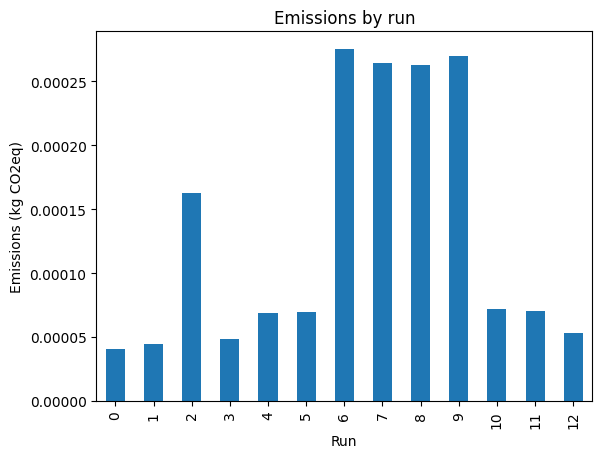

In [29]:
df_emissions.emissions.plot(kind='bar',title='Emissions by run',xlabel='Run',ylabel='Emissions (kg CO2eq)')

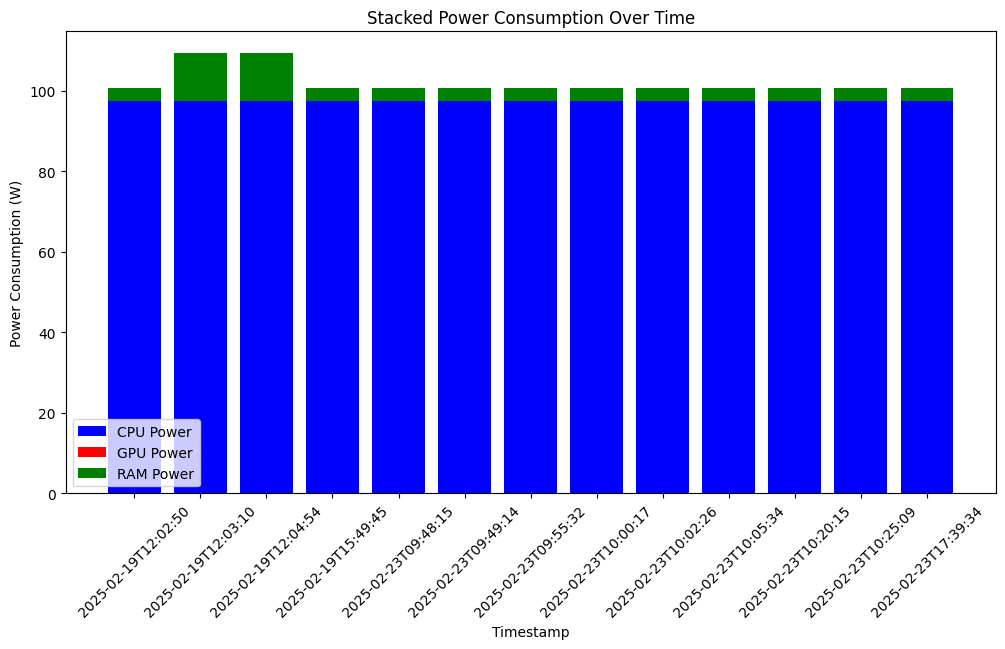

In [36]:
plot_stacked_power(df_emissions)

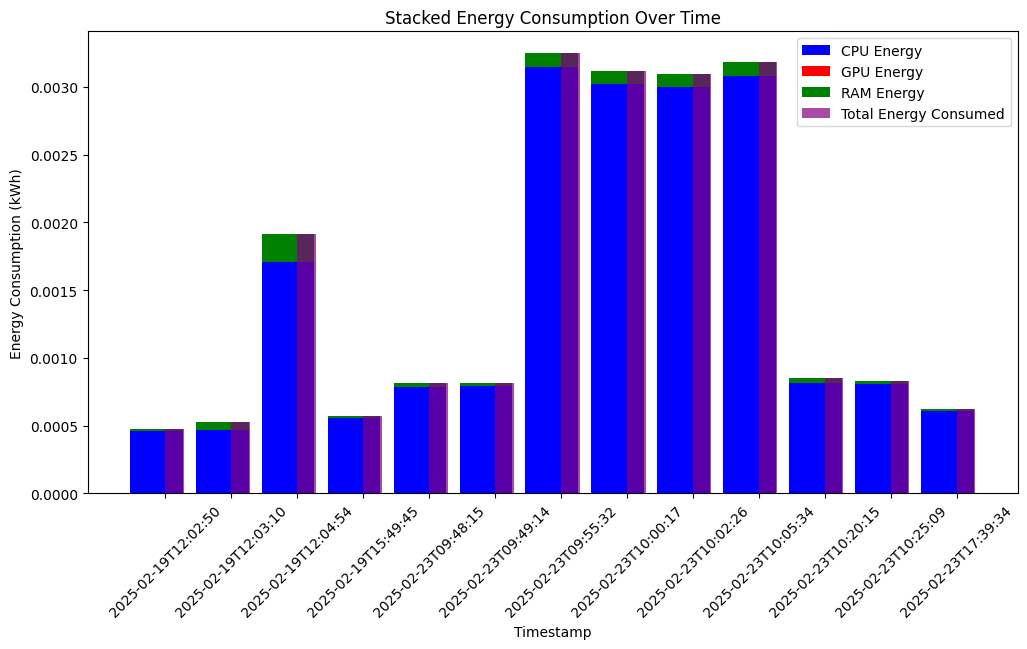

In [ ]:

plot_stacked_energy(df_emissions)